In [1]:
import os

file_path = 'archive-2'

if os.path.exists(file_path):
    print("File found!")
else:
    print("File not found.")


File found!


In [2]:
len('archive-2')

9

# Imports Libraries and Tools

In [3]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data
from sklearn.utils import shuffle

In [4]:
train_dir = 'archive-2/Training'
test_dir = 'archive-2/Testing'


In [5]:
print(f"Total training images: {len(train_dir)}")
print(f"Total testing images: {len(test_dir)}")

Total training images: 18
Total testing images: 17


# Load Datasets

In [6]:
import os
from sklearn.utils import shuffle

# Load and shuffle dataset paths and labels
def prepare_dataset(dataset_dir):
    file_paths = []
    targets = []
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.startswith('.'):
                    continue
                file_paths.append(os.path.join(folder_path, img_file))
                targets.append(folder)
    return shuffle(file_paths, targets)

# Fetch training and test data
train_files, train_classes = prepare_dataset(train_dir)
test_files, test_classes = prepare_dataset(test_dir)

# Info
print(f"Total Training Images: {len(train_files)}")
print(f"Total Test Images: {len(test_files)}")


Total Training Images: 5712
Total Test Images: 1311


# Data Visualization

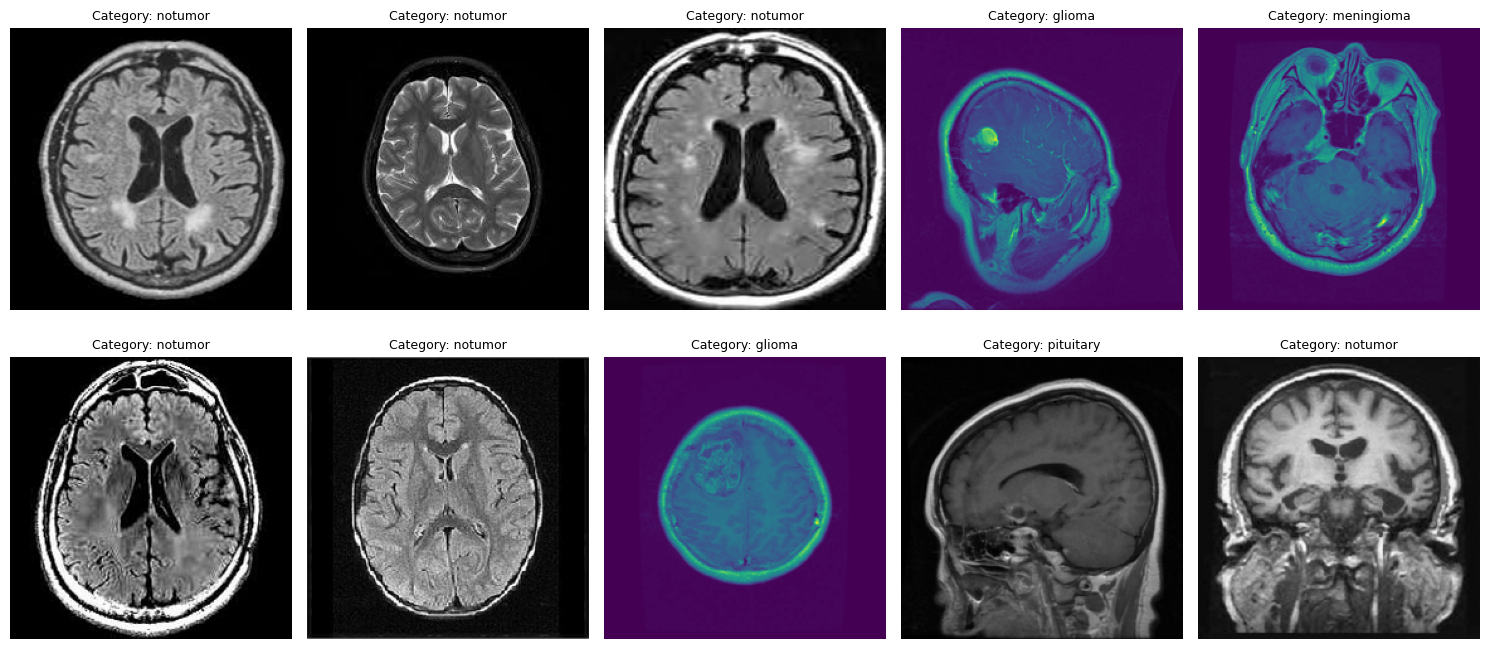

In [7]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Show sample images
sample_indices = random.sample(range(len(train_files)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    img = Image.open(train_files[idx]).resize((224, 224))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Category: {train_classes[idx]}", fontsize=9)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [8]:
import numpy as np
from PIL import ImageEnhance
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder

# Brightness and contrast variation
def transform_image(img):
    img = Image.fromarray(np.uint8(img))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2))
    return np.array(img) / 255.0

# Load images with preprocessing
def preprocess_images(file_list):
    processed = []
    for f in file_list:
        raw = load_img(f, target_size=(IMAGE_DIM, IMAGE_DIM))
        transformed = transform_image(raw)
        processed.append(transformed)
    return np.array(processed)

# Label encoding
def convert_labels(labels):
    unique = os.listdir(train_dir)
    return np.array([unique.index(lbl) for lbl in labels])

# Batch generator
def batch_generator(paths, labels, batch_size=12, num_epochs=1):
    for _ in range(num_epochs):
        for i in range(0, len(paths), batch_size):
            yield (
                preprocess_images(paths[i:i + batch_size]),
                convert_labels(labels[i:i + batch_size])
            )


# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

IMAGE_DIM = 128
vgg_base = VGG16(input_shape=(IMAGE_DIM, IMAGE_DIM, 3), include_top=False, weights='imagenet')

# Freeze all but last 3 layers
for layer in vgg_base.layers:
    layer.trainable = False
for l in vgg_base.layers[-3:]:
    l.trainable = True

# Build model
cnn_model = Sequential([
    Input(shape=(IMAGE_DIM, IMAGE_DIM, 3)),
    vgg_base,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# Compile
cnn_model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

# Train
BATCH = 20
STEP_COUNT = len(train_files) // BATCH
EPOCHS = 5

history = cnn_model.fit(batch_generator(train_files, train_classes, batch_size=BATCH, num_epochs=EPOCHS),
                        epochs=EPOCHS, steps_per_epoch=STEP_COUNT)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 169s 593ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.7412
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 176s 620ms/step - loss: 0.2595 - sparse_categorical_accuracy: 0.9006
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 178s 626ms/step - loss: 0.2007 - sparse_categorical_accuracy: 0.9232
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 183s 644ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9441
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 207s 726ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.9538


# Train and Val Plots

41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
Evaluation Metrics:

              precision    recall  f1-score   support

           0       1.00      0.90      0.94       300
           2       0.99      0.99      0.99       405
           3       0.96      0.90      0.93       300
           4       0.83      0.97      0.90       306

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311



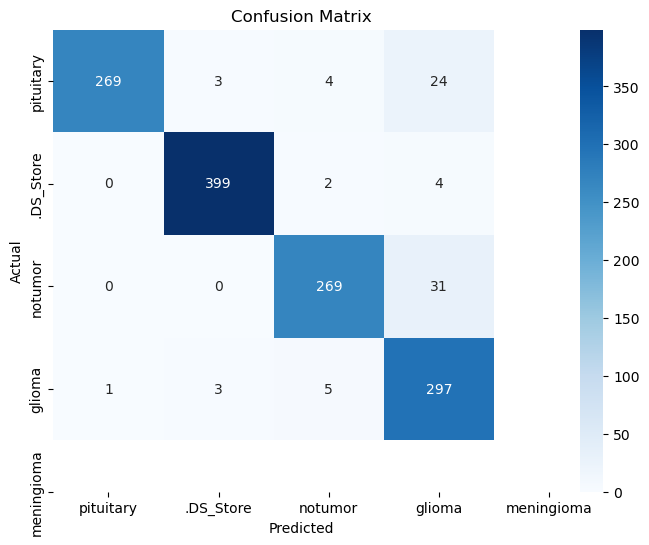

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


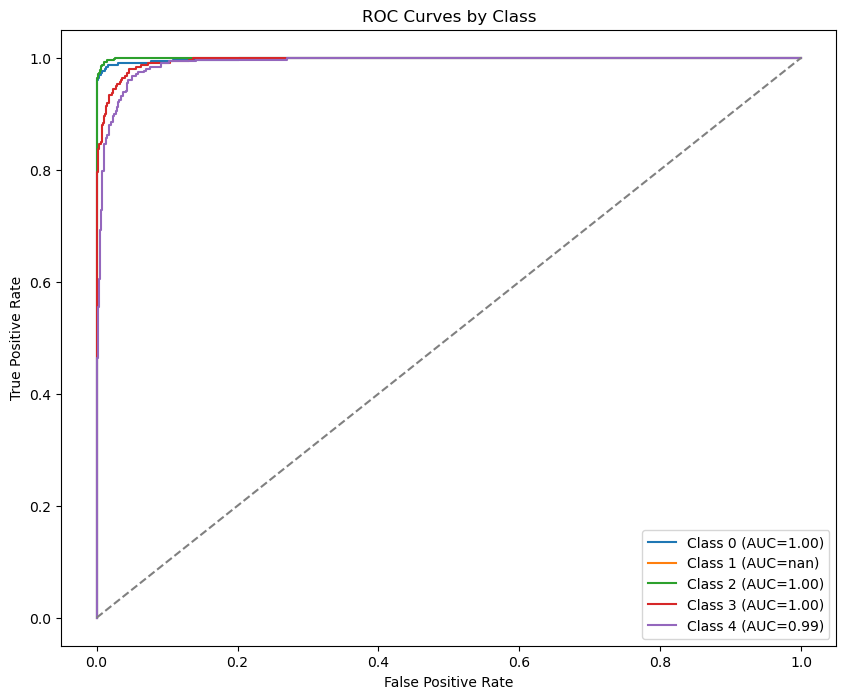

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = preprocess_images(test_files)
y_test = convert_labels(test_classes)

# Predictions
y_pred_proba = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification metrics
print("Evaluation Metrics:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d",
            xticklabels=os.listdir(train_dir),
            yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
bin_true = label_binarize(y_test, classes=np.arange(len(os.listdir(train_dir))))
plt.figure(figsize=(10, 8))
for i in range(bin_true.shape[1]):
    fpr, tpr, _ = roc_curve(bin_true[:, i], y_pred_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Save & Load Model

In [11]:
# Save the entire model
cnn_model.save('MY_model.h5')

In [12]:
from tensorflow.keras.models import load_model
model = load_model('MY_model.h5')

# MRI Tumor Detection System

In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# New class labels
tumor_classes = ['pituitary', 'glioma', 'notumor', 'meningioma']

def classify_and_visualize(image_path, trained_model, target_size=128):
    """
    Detects tumor type in the given image and displays the result.
    Shows 'No Tumor' if detected class is 'notumor', else displays the tumor type and confidence.
    """
    try:
        # Load and preprocess the image
        loaded_image = load_img(image_path, target_size=(target_size, target_size))
        image_array = img_to_array(loaded_image) / 255.0  # Normalize pixel values
        image_array = np.expand_dims(image_array, axis=0)  # Expand dimensions for batch input

        # Make prediction
        prediction_probs = trained_model.predict(image_array)
        predicted_index = np.argmax(prediction_probs, axis=1)[0]
        prediction_confidence = np.max(prediction_probs, axis=1)[0]

        # Interpret results
        if tumor_classes[predicted_index] == 'notumor':
            prediction_result = "No Tumor"
        else:
            prediction_result = f"Tumor: {tumor_classes[predicted_index]}"

        # Display image and prediction
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{prediction_result} (Confidence: {prediction_confidence * 100:.2f}%)")
        plt.show()

    except Exception as err:
        print("Failed to process image:", str(err))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


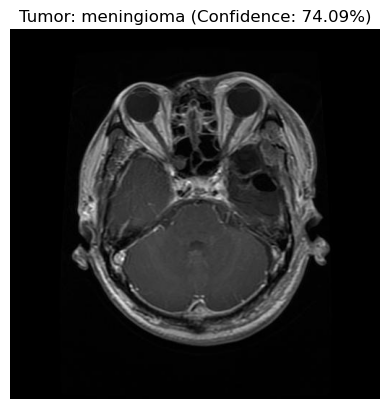

In [14]:
# Example usage
image_path = 'archive-2/Testing/glioma/Te-gl_0011.jpg'  # Provide the path to your new image
classify_and_visualize(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


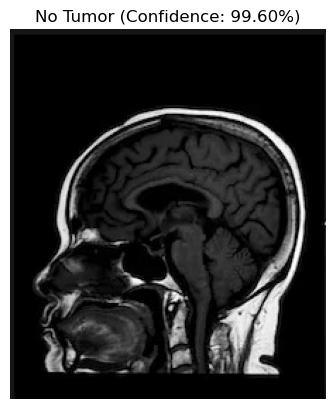

In [15]:

# Example usage
image_path = 'archive-2/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
classify_and_visualize(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


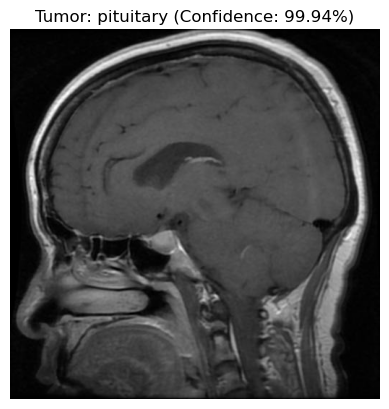

In [16]:
# Example usage
image_path = 'archive-2/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
classify_and_visualize(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


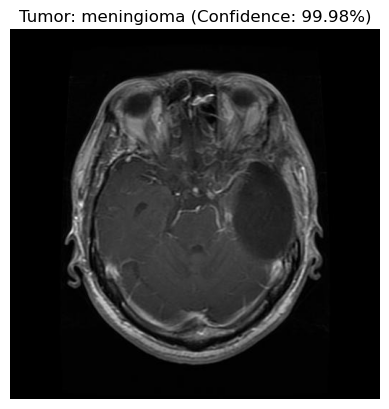

In [17]:
# Example usage
image_path = 'archive-2/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
classify_and_visualize(image_path, model)